# Contest with risk averse bidders and non-monetary effort

Here we use a simple example where contestants are risk averse with respect to prize money. Put differently, the expected utility of a contestant with cost parameter $c_i$ when exerting effort $x_i$ is $p_1(x_i) u(V_1)+p_2(x_i) u(V_2)-c_i x_i$ where $p_j(x_i)$ is the probability of winning $j$'th prize when exertin effort $x_i$ (given the equilibrium strategies of the other contestants) and $u$ is a strictly increasing and concave Bernoulli utility function. The contestant is risk averse with respect to prize money because $u$ is concave.

In this model, the costs of effort are non-monetary and certain. The only uncertain part is which prize (if any) the contestant wins. (If the cost of effort was monetary, we would have to use the utility function $p_1(x_i) u(V_1-c_i x_i)+p_2(x_i) u(V_2-c_i x_i)$ which would complicate the analysis).

The model with non-monetary effort cost is relatively simple because the game of the contestants (for given prizes $V_1$ and $V_2$) is the same as in Moldovanu and Sella: Instead of $V_1$ we simply have to use $W_1=u(V_1)$ and instead of $V_2$ we use $W_2=u(V_2)$. The same analysis as in the paper gives the equilibrium strategies for the contestants $b(c) = A(c)W_1+B(c)W_2$ where $A(c)$ and $B(c)$ are as in the paper. The only small difference is in the designer's problem: The constraint that the total prize money equals 1 states $V_1+V_2=1$ which in terms of $W_j$ reads $u^{-1}(W_1)+u^{-1}(W_2)=1$. Hence, the constraint when optimizing over $W_1$ and $W_2$ is $W_2=u(1-u^{-1}(W_1))$.

The code below computes the optimal first and second prizes if cost parameters are iid uniformly distributed between 0.5 and 1 and there are 3 contestants. Here we get an interior solution: the first prize is $\approx 2/3$ and the second prize $\approx 1/3$. The intuition is that giving more prize money to the good types (via a higher first prize) does not give a lot of additional utility to them (because $u$ is concave, i.e. the marginal utility is decreasing). However, the marginal utility of the second prize is rather high (with the square root utility below it is actually infinite at 0) and can therefore motivate contestants (in particular those with medium and high cost parameters) considerably. Note that the code below only allows for 2 prizes. You should be able to convince yourself that probably 3 unequal prizes are optimal in this example (I did not allow for a third prize in order to be able to use the same formulas for the agents' strategies that we had in the lecture).

 
Optimal first prize is 0.6719864163174155
Optimal second prize is 0.3280135836825845


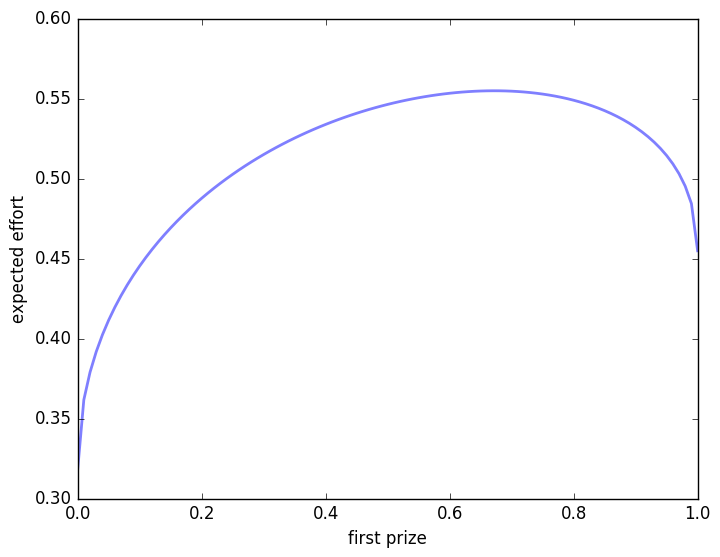

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7b12383d68>

In [2]:
#load plotting package
using PyPlot
#load optimization package
using Optim

#########Setting up the primitives of the model#############

#lower bound type distribution
const m = 0.5

#number of contestants
const k = 3

#cdf of type distribution; here uniform
function F(a::Float64)
    if m<= a<= 1.0
        return (a-m)/(1.0-m)
    elseif a<m
        return 0.0
    else 
        return 1.0
    end
end

#pdf of type distribution; here uniform
function f(a::Float64)
    if m<= a<= 1.0
        return 1.0/(1.0-m)
    else 
        return 0.0
    end
end    

#Bernoulli utility of prize money; here √x
function u(x::Float64)
    return sqrt(x)
end

#inverse of the Bernoulli utility function of prize money; here x^2
function uinv(v::Float64)
    return v^2
end

############Setting up the equilibrium strategies of the contestants###########
A(c) = (k-1)*quadgk(a-> (1-F(a))^(k-2) * f(a)/a,c,1)[1] #"quadgk" integrates the function (1st argument) using the 2nd and 3rd argument as boundaries
B(c) = (k-1)*quadgk(a-> (1-F(a))^(k-3) * ((k-1)*F(a)-1) * f(a)/a,c,1)[1]

b(W1,W2,c) = A(c)*W1 + B(c)*W2

####### Designer's problem ########
#this function returns the expected effort of a participant multiplied with -1 (as the optimization procedure below searches for the minimum)
function minusobjective(W1::Float64)
    function wrapped_objective(c::Float64)
        return b(W1,u(1.0-uinv(W1)),c)*f(c) #note that W2 = u(1.0-uinv(W1)) by the constraint V1+V2=1
    end
    return (-1.0)*quadgk(wrapped_objective,m,1)[1]
end

#result to optimization problem (minimizes "minusobjective" with W1 between u(0.5) and u(1.0); note that V1 cannot be less than 0.5)
r = optimize(minusobjective,u(0.5),u(1.0))

println(" ")
println("Optimal first prize is ", uinv(r.minimum))
println("Optimal second prize is ", 1.0-uinv(r.minimum))

#for plotting: returns average effort of a contestant if first prize is V1
function plotobjective(V1::Float64)
    return (-1.0)*minusobjective(u(V1))
end
function plotobjective(V1::FloatRange{Float64})
    return [(-1.0)*minusobjective(u(v)) for v in V1]
end

fig, ax = subplots()
ax[:set_xlabel]("first prize")
ax[:set_ylabel]("expected effort")
ax[:plot](0.0:0.01:1.0,plotobjective(0.0:0.01:1.0),"b-",linewidth=2,alpha=0.5)


Can we say in general when multiple prizes are optimal in this model? It turns out we can! 
Let's again concentrate on 2 prizes and let us check when it is optimal to have the second prize greater than 0. The expected effort of a participant is 

$$\int_m^1\left(W_1 A(c)+u(1-u^{-1}(W_1)) B(c)\right)\,f(c) \,dc$$

where we use the constraint $W_2 = u(1-u^{-1}(W_1))$ which states that the two prizes have to add up to 1. Maximizing this expression over $W_1$ leads to the first order condition

$$\int_m^1\left( A(c)- u'(1-u^{-1}(W_1))*u^{-1}{ }'(W_1)* B(c)\right)\,f(c) \,dc\quad\square\quad 0$$
with $\square$ being "=" if $1/2<V_1<1$, being "$\geq$" is $V_1=1$ and "$\leq$" if $V_1=1/2$. This can be rewritten as
$$\frac{\int_m^1  A(c)f(c)\,dc}{\int_m^1 B(c)f(c)\,dc}\quad \square \quad u'(1-u^{-1}(W_1))*u^{-1}{ }'(W_1).$$

The fraction on the left hand side is a constant -- call it $LHS$ -- that can readily be calculated form the primitives of the model (it does not depend on the prizes). If $V_1=1$, then $W_1=u(1)$ and the right hand side becomes $RHS_1 = u'(0)*u^{-1}{ }'(u(1))=u'(0)/u'(1)$. If $RHS_1$ exceeds $LHS$, then we can conclude that $V_1$ has to be less than 1 (as the first order condition cannot be satisfied for $V_1=1$). 

*Result 1: If* 
$$u'(0)/u'(1)>\frac{\int_m^1  A(c)f(c)\,dc}{\int_m^1 B(c)f(c)\,dc},$$
*then the optimal first prize is interior.*

With the square root utility function, which has $u'(0)=\infty$, this is obviously the case.

Can we find a condition that rules out that two equal prizes are optimal? Take $V_1=0.5$ which implies $W_1=u(1/2)$. The right hand side of the rewritten first order conditions becomes $RHS_{0.5}=u'(1/2)*u^{-1}{}'(u(1/2))=u'(1/2)/u'(1/2)=1$. This yields the next result.

*Result 2: If *
$$ \frac{\int_m^1  A(c)f(c)\,dc}{\int_m^1 B(c)f(c)\,dc}>1,$$
*then $V_1>1/2$.*

With our square root utility function it is easy to check that the condition of result 2 is satisfied:

In [17]:
((quadgk(c->A(c)*f(c),m,1)[1])^2) / ((quadgk(c->B(c)*f(c),m,1)[1])^2 )

2.048654292692943

In fact, we could have solved for the optimal first prize (in the two prizes case) in our example above by using the first order condition above (with "=" as we now established that the solution is interior). Note that 
$u'(1-u^{-1}(W_1))*u^{-1}{ }'(W_1)=\frac{W_1}{\sqrt{1-W_1^2}}$ with the square root utility function which means that the first order condition can be written as 
$$\frac{\int_m^1  A(c)f(c)\,dc}{\int_m^1 B(c)f(c)\,dc}=\frac{W_1}{\sqrt{1-W_1^2}}$$
which can be rearranged to yield
$$W_1=\sqrt{\frac{\left(\int_m^1  A(c)f(c)\,dc\right)^2}{\left(\int_m^1  A(c)f(c)\,dc\right)^2+\left(\int_m^1 B(c)f(c)\,dc\right)^2}}.$$
As $V_1=u^{-1}(W_1)=W^2_1$, we then get
$$V_1=\frac{\left(\int_m^1  A(c)f(c)\,dc\right)^2}{\left(\int_m^1  A(c)f(c)\,dc\right)^2+\left(\int_m^1 B(c)f(c)\,dc\right)^2}.$$
Indeed this gives the same result that we obtained above:

In [18]:
(quadgk(c->A(c)*f(c),m,1)[1])^2 / ((quadgk(c->B(c)*f(c),m,1)[1])^2+(quadgk(c->A(c)*f(c),m,1)[1])^2 )

0.6719864228630928